In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from openpyxl import load_workbook
import csv
import pandas as pd

In [57]:
rppa_M = os.path.join('../dataset/tumour_microenv_results_2020-9/rppa/Tensorly','M_rppa_tensorly.xlsx')
gcp_M = os.path.join('../dataset/tumour_microenv_results_2020-9-3/gcp/Tensorly','M_gcp_tensorly.xlsx')

rppa_M1 = pd.read_excel(rppa_M, sheet_name='M1_AB').set_index('Protein')
gcp_M1 = pd.read_excel(gcp_M, sheet_name='M1_AB').set_index('Histone')
print('rppa_M1', rppa_M1.shape)
print('gcp_M1', gcp_M1.shape)

rppa_M1 (274, 6)
gcp_M1 (58, 6)


In [58]:
rppa_M1_mat = rppa_M1.values.T
gcp_M1_mat = gcp_M1.values.T
print('rppa_M1_mat', rppa_M1_mat.shape)
print('gcp_M1_mat', gcp_M1_mat.shape)

rppa_M1_mat (6, 274)
gcp_M1_mat (6, 58)


In [59]:
# To test the PLSR model

from sklearn.cross_decomposition import PLSRegression
# X = [[0., 0., 1., 2,2], 
#      [1.,0.,0.,3,1], 
#      [2.,2.,2.,1,2], 
#      [2.,5.,4.,1,4]]

# Y = [[0.1, -0.2, 1.,2.], 
#      [0.9, 1.1, 2.,4.], 
#      [6.2, 5.9, 1.,1.], 
#      [11.9, 12.3, 1.,2.]]
pls2 = PLSRegression(n_components=5)
pls2.fit(rppa_M1_mat, gcp_M1_mat)
print(pls2.coef_.shape)
# pls2.coef_

(274, 58)


E:\softwareInstall\Anaconda3\envs\localpython\lib\site-packages\sklearn\cross_decomposition\_pls.py:351: UserWarning: X scores are null at iteration 2
  warnings.warn('X scores are null at iteration %s' % k)


In [60]:
coefficient_mat = pd.DataFrame(data=pls2.coef_, index=rppa_M1.index, columns=gcp_M1.index)
coefficient_mat_abs = np.absolute(coefficient_mat)
coefficient_mat_mean = coefficient_mat_abs.mean(axis=1)

coefficient_mat_abs['Avg'] = coefficient_mat_mean.values
writer = pd.ExcelWriter('../dataset/tumour_microenv_results_2020-9/coef_histone_by_protein_tensorly.xlsx')

coefficient_mat.to_excel(writer, 'original')
coefficient_mat_abs.to_excel(writer, 'absolute_processed')
writer.save()

In [61]:
coefficient_mat_mean.to_frame()

,0
Protein,
ACTB,0.000033
ADAR,0.000345
AKT1S1,0.000034
ARAF,0.000316
ARID1A,0.000345
...,...
WEE1pS642,0.000259
WWTR1,0.000233
XRCC1,0.000118


mean:0.0001695771813056335, std:9.819351851663318e-05


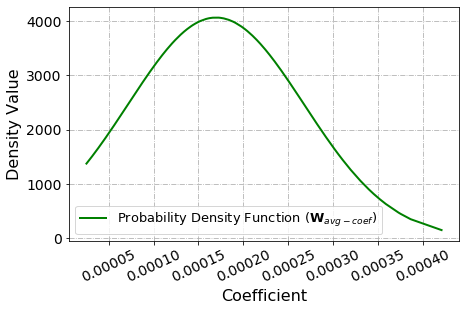

In [62]:
from scipy.stats import norm
fig = plt.figure(figsize=(7, 4.3))
ax = fig.add_subplot(111)
ax.tick_params(axis='both', which='major', labelsize=14)

ph_cor_avg = np.array(coefficient_mat_mean.values)
ph_cor_avg.sort()
mean, std = norm.fit(ph_cor_avg)
print('mean:{}, std:{}'.format(mean, std))

fitted_pdf = norm.pdf(ph_cor_avg, loc=mean, scale=std)
linestyle = {"linestyle":"-", "linewidth":2, "markeredgewidth":2, "elinewidth":2, "capsize":5}
plt.errorbar(ph_cor_avg, fitted_pdf, color="green", **linestyle, fmt='-')
plt.xlabel("Coefficient", fontsize=16)
plt.ylabel("Density Value", fontsize=16)
plt.legend(['Probability Density Function ($\mathbf{W}_{avg-coef}$)'], fontsize=13)
plt.grid(linestyle='-.')
plt.xticks(rotation=25)

intense_density = np.concatenate([ph_cor_avg, fitted_pdf]).reshape(2, ph_cor_avg.shape[0]).transpose([1,0])
intense_density_mat = pd.DataFrame(data=intense_density, columns=['Intensity','Dnesity'])
intense_density_mat.loc[-1] = [mean, std]
intense_density_mat.index = intense_density_mat.index + 1
intense_density_mat = intense_density_mat.sort_index()
intense_density_mat.rename(index = {0: "mean/std"}, inplace = True)
intense_density_mat.to_excel(writer, "M_coef_Intensity_dist")
writer.save()

In [81]:
M_mean = 0.0001695771813056335

#------------------center_MeanElbow-----------------
M_cutoff = 0.0002595097678872271 - M_mean

coe_mean_frame = coefficient_mat_mean.to_frame()
coe_mean_frame.columns = ['Itensity']
rppa_gcp_stack_sorted = coe_mean_frame[~((coe_mean_frame.values-M_mean < M_cutoff))]#.sort_values(by='Itensity',ascending=False)
rppa_gcp_stack_sorted.to_excel(writer, 'M_coef_center_MeanElbow')
writer.save()


#------------------elbow-----------------
M_cutoff = 0.00034534 - M_mean

coe_mean_frame = coefficient_mat_mean.to_frame()
coe_mean_frame.columns = ['Itensity']
rppa_gcp_stack_sorted_elbow = coe_mean_frame[~((coe_mean_frame.values-M_mean < M_cutoff))]#.sort_values(by='Itensity',ascending=False)
rppa_gcp_stack_sorted_elbow.to_excel(writer, 'M_coef_Elbow')
writer.save()

#------------------Asymptotic-----------------
M_cutoff = 0.000426993 - M_mean

coe_mean_frame = coefficient_mat_mean.to_frame()
coe_mean_frame.columns = ['Itensity']
rppa_gcp_stack_sorted = coe_mean_frame[~((coe_mean_frame.values-M_mean < M_cutoff))]#.sort_values(by='Itensity',ascending=False)
rppa_gcp_stack_sorted.to_excel(writer, 'M_coef_Asymptotic')
writer.save()


In [74]:
coefficient_mat_selected

Histone,H3K9me2S10ph1K14ac0,H3K9me3S10ph1K14ac0,H3K18ub1K23ac0,H4(20to23)K20me0,H3K4ac1
Protein,,,,,
COL6A1,-0.000388,-0.000375,-0.000116,-0.000038,0.001670
EGFRpY1173,-0.000404,-0.000391,-0.000122,-0.000044,0.001718
EIF4EBP1,-0.000364,-0.000351,-0.000106,-0.000030,0.001599
ESR1pS118,-0.000354,-0.000341,-0.000102,-0.000027,0.001569
MCL1,-0.000455,-0.000441,-0.000142,-0.000061,0.001866
PRKCDpS664,-0.000384,-0.000371,-0.000114,-0.000037,0.001659


In [66]:
seleted_proteins = rppa_gcp_stack_sorted_elbow.index
selected_histones = ['H3K9me2S10ph1K14ac0 ', 'H3K9me3S10ph1K14ac0 ', 'H3K18ub1K23ac0 ', 
                     'H4(20to23)K20me0', 'H3K4ac1 ']

coefficient_mat_ = coefficient_mat[coefficient_mat.index.isin(seleted_proteins)]
coefficient_mat_selected = coefficient_mat_[selected_histones]


(coefficient_mat_selected*1000).to_excel(writer, "selected_protein_histone")
writer.save()

In [82]:
rppa_gcp_stack_sorted_elbow

,Itensity
Protein,
COL6A1,0.000375
EGFRpY1173,0.000387
EIF4EBP1,0.000359
ESR1pS118,0.000352
MCL1,0.000421
PRKCDpS664,0.000373


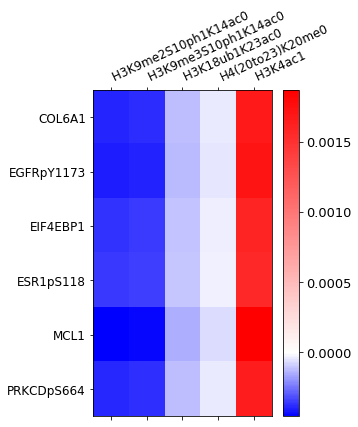

In [68]:
from matplotlib import colors

fig = plt.figure(figsize=(4,6))
ax = fig.add_subplot(111)
plt.set_cmap('bwr')
norm = colors.DivergingNorm(vcenter=0)
aa = ax.matshow(coefficient_mat_selected.values,norm =norm)
ax.set_aspect('auto')

ax.set_yticks(np.arange(len(seleted_proteins)))
ax.set_yticklabels(coefficient_mat_selected.index.tolist(), fontsize=12)
# ax.set_yticks(['1','2'])
ax.set_xticklabels(coefficient_mat_selected.columns.insert(0,''), rotation=25, fontsize=12, ha="left")
# ax.set_title('$\mathbf{W}_{coef}$', y=-0.1, fontsize=16)
plt.rc('ytick',labelsize=13)
fig.colorbar(aa)

In [1]:
# rppa_M2_per_ligands = pd.read_excel(rppa_M, sheet_name='M2_AC_per_ligands').set_index('Unnamed: 0')
# m2_vs = rppa_M2_per_ligands[rppa_M2_per_ligands.index.isin(seleted_proteins)].apply(pd.to_numeric, errors='ignore').values


# labs = [['','4hr','EGF\n\n8hr','24hr','48hr'],
#        ['','4hr','HGF\n\n8hr','24hr','48hr'],
#        ['','4hr','OSM\n\n8hr','24hr','48rh'],
#        ['','4hr','BMP2\n\n8hr','24hr','48hr'],
#        ['','4hr','IFNG\n\n8hr','24hr','48hr'],
#        ['','4hr','TGFB\n\n8hr','24hr','48hr']]
# # ax.set_xticklabels(labs, fontsize=15)

# pathways = {'Apoptosis':[1,5,7],
#             'Cell adhesion':[0],
#             'Cell cycle':[0,4,5,7],
#             'Cell migration':[0],
#             'Cell motility':[0,3],
#             'Differentiation':[4,5,6,7],
#             'Focal adhesion':[2,3],
#             'Inflammation':[8],
#             'Proliferation':[3,5,7,8],
#             'Regulation of autophagy':[6]}

# # fig = plt.figure(figsize=(20,36))
# layer = len(pathways)
# fig, axes = plt.subplots(layer,6,figsize=(24,26),sharey=False,sharex=False,gridspec_kw = {'height_ratios':[3,1,4,1,2,4,2,1,4,1]})

# # cb=fig.colorbar(aa, pad=0.03)
# # cb.set_clim(-0.4, 0.6)
# # cb.ax.tick_params(labelsize=15)


# layer = len(pathways)
# i = 0
# for k in pathways.keys():
    
#     protein_ids = pathways[k]
    
#     # plt.subplot(1, 4, 1)
# #     ax = fig.add_subplot(layer,6,i*6+1)
#     ax = axes[i][0]
#     plt.set_cmap('bwr')
#     norm = colors.DivergingNorm(vcenter=0)
#     aa = ax.matshow(m2_vs[protein_ids,0:4],norm =norm)
#     ax.set_aspect('auto')
#     ax.xaxis.tick_top()
#     ylabs = ['']+list(np.array(ylab_list)[protein_ids])
# #     ylabs = ['']+list(np.array(coefficient_mat_selected.index.to_list())[protein_ids])
#     if len(ylabs) == 2:
#         ylabs = ['',''] + ylabs +['']
#         ax.tick_params(direction='out', axis ='y', width=0)
#     ax.set_yticklabels(ylabs, fontsize=18)
#     ax.set_xticklabels([])
#     aa.set_clim(-0.4, 0.6)
#     if i == 0:
#         ax.xaxis.tick_top()
#         ax.set_xticklabels(labs[0], fontsize=18)

# #     ax = fig.add_subplot(layer,6,i*6+2)
#     ax = axes[i][1]
#     plt.set_cmap('bwr')
#     norm = colors.DivergingNorm(vcenter=0)
#     aa = ax.matshow(m2_vs[protein_ids,4:8],norm =norm)
#     ax.set_aspect('auto')
#     ax.xaxis.tick_top()
#     ax.set_xticklabels([])
#     aa.set_clim(-0.4, 0.6)
#     if i == 0:
#         ax.set_xticklabels(labs[1], fontsize=18)
#     if len(ylabs) == 5:
#         ax.tick_params(direction='out', axis ='y', width=0)
#     ax.set_yticklabels([])

# #     ax = fig.add_subplot(layer,6,i*6+3)
#     ax = axes[i][2]
#     plt.set_cmap('bwr')
#     norm = colors.DivergingNorm(vcenter=0)
#     aa = ax.matshow(m2_vs[protein_ids,8:12],norm =norm)
#     ax.set_aspect('auto')
#     ax.xaxis.tick_top()
#     ax.set_xticklabels([])
#     aa.set_clim(-0.4, 0.6)
#     if len(ylabs) == 5:
#         ax.tick_params(direction='out', axis ='y', width=0)
#     if i == 0:
#         ax.set_xticklabels(labs[2], fontsize=18)
#     ax.set_yticklabels([])

# #     ax = fig.add_subplot(layer,6,i*6+4)
#     ax = axes[i][3]
#     plt.set_cmap('bwr')
#     norm = colors.DivergingNorm(vcenter=0)
#     aa = ax.matshow(m2_vs[protein_ids,12:16],norm =norm)
#     ax.set_aspect('auto')
#     ax.xaxis.tick_top()
#     ax.set_xticklabels([])
#     aa.set_clim(-0.4, 0.6)
#     if len(ylabs) == 5:
#         ax.tick_params(direction='out', axis ='y', width=0)
#     if i == 0:
#         ax.set_xticklabels(labs[3], fontsize=18)
#     ax.set_yticklabels([])

# #     ax = fig.add_subplot(layer,6,i*6+5)
#     ax = axes[i][4]
#     plt.set_cmap('bwr')
#     norm = colors.DivergingNorm(vcenter=0)
#     aa = ax.matshow(m2_vs[protein_ids,16:20],norm =norm)
#     ax.set_aspect('auto')
#     ax.xaxis.tick_top()
#     ax.set_xticklabels([])
#     aa.set_clim(-0.4, 0.6)
#     if len(ylabs) == 5:
#         ax.tick_params(direction='out', axis ='y', width=0)
#     if i == 0:
#         ax.set_xticklabels(labs[4], fontsize=18)
#     ax.set_yticklabels([])

# #     ax = fig.add_subplot(layer,6,i*6+6)
#     ax = axes[i][5]
#     plt.set_cmap('bwr')
#     norm = colors.DivergingNorm(vcenter=0)
#     aa = ax.matshow(m2_vs[protein_ids,20:24],norm =norm)
#     ax.set_aspect('auto')
#     ax.set_xticklabels([])
#     aa.set_clim(-0.4, 0.6)
#     if len(ylabs) == 5:
#         ax.tick_params(direction='out', axis ='y', width=0)
#     if i == 0:
#         ax.set_xticklabels(labs[5], fontsize=18)
#     ax.set_yticklabels([])
#     i+=1


# fig.subplots_adjust(right=0.84, wspace = .10, hspace=0.12)
# cbar_ax = fig.add_axes([0.85, 0.25, 0.015, 0.5])
# aa.set_clim(-0.4, 0.6)
# cb = fig.colorbar(aa, cax=cbar_ax)
# cb.ax.tick_params(labelsize=18)